# Weighted MAXCUT Problem

## Problem Statement : 
The [MaxCut problem](https://en.wikipedia.org/wiki/Maximum_cut) is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At [this link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.

# Required Installation and Imports

In [ ]:
!pip install pennylane --upgrade

In [2]:
import pennylane as qml
from pennylane import numpy as np

# Test Cases

Each of the test cases here basically represented by three parameters. 

1. n_wires which denotes number of nodes in the graph as well as the number of qubits that  will be used in the quantum circuit. 

2. graph - each element of this list represents each edge of the graph by mentioning the number of two nodes of that edge. 

3. weight - this list contains information about the weights associated with each nodes. 

Importantly, the sequance of edges followed in the 'graph', the same sequence must be followed in the 'weight' too. 

In [3]:
n_wires = 3
graph = [(0,1), (1,2), (0,2)]
weight = [10, 1, 10]


# n_wires = 4
# graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
# weight = [1, 1, 1, 1]



# n_wires = 5
# graph = [(0,1), (0,2), (1,2), (1,3), (2,3), (3,4)]
# weight = [5, 1, 7, 4, 2, 3]




Test cases written here are commented out because the purpose here is to just show the format we are following to represent the wighted graph. All the test cases has been tested upon in the later section with proper description and visualization. 

# Theoretical Discussion

The main moto of this problem is to seperate the whole set of nodes in two subsets $A$ and $B$ such that the sum of weights of edges that have different types of nodes at their ends become the maximum possible value. 

In other words, we have to find a partition through the whole graph, such that sum of weights of edges that the partition passes becomes the maximum among all possible cuts. 

We can convert this to a simple mathematical expression. 

>>>$C(z) = \sum \limits _{\alpha=1} ^{m} C_{\alpha}(z) $



Here $C(z)$ represents the score of a specific partition through the graph. $\alpha$ iterates from 1 to m where m is the number of edges present. for each edge, $C_{\alpha}(z)$ represents the score associated with each edge. $C_{\alpha}(z)$ is equal to the weight of the edge if the partition passes through that edge and equal to $0$, if not. 



# Representing in terms of Quantum Circuit

As we have already defined a score value for a cut, we have to define that in terms of unitary ooperators that can be implemented on the quantum circuit. 

While representing the partition using computational basis states, we can represent the terms in $C(z)$ as operators acting on the states. 

>>> $C_{\alpha} = \frac{1}{2} W (1-\sigma_z^j \sigma_z^k) $

Here the $\alpha$th edge is the edge connecting $j$th and $k$th nodes. For each node $C_{\alpha}$ will be equal to the weight of the edge if the partition goes between $j$th and $k$th nodes and equal to $0$ if doesn't pass because the operator $(1-\sigma_z^j \sigma_z^k)$ has eigenvalue $1$, iff $j$th and $k$th qubit have different z-axis measurement values. 




Initially the circuit is converted to equal superposition state by applying Hadamard gate in each individual qubit, also known as $|+_{n}>$ state. 

The circuit consists of $L$ layers of $U_B$ and $U_C$ gates. In each layer, one $U_B$ and one $U_C$ is associated with one $\beta$ and $\gamma$ parameter. Therefore each layers having 2 params $\beta$ and $\gamma$, the whole $L$ layered circuit is consist of $2L$ parameters. 

Now coming to each of the layers, $U_B$ is single qubit operator, implemented on each of the individual qubits and it is basically a $R_X$ gate with parameter $2\beta$. $U_C$ whereas acts on two qubits. It is implemented on those two nodes who are connected by an edge in the graph. $U_C$ consists of a $R_Z$ gate with parameter $(-w\gamma)$ sandwitched between two CNOT gates. 

## Defining $U_B$ operator

In [4]:
def U_B(beta):
    for qubit in range(n_wires):
        qml.RX(2*beta, wires=qubit)

## Defining $U_C$ operator

In [5]:
def U_C(gamma):
    for idx in range(n_wires):

        qubit1 = graph[idx][0]
        qubit2 = graph[idx][1]
        w = weight[idx]
        
        qml.CNOT(wires = [qubit1, qubit2])
        qml.RZ((-1)*w*gamma, wires = qubit2)
        qml.CNOT(wires = [qubit1, qubit2])

        

## Computational Basis Measurement

To sample a measurement of multiple qubits in computational basis, we define this Hermitian operator. The eigenvalues of the operator are the qubit measurement values in integer form.

In [6]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

# Creating the circuit

First we are creating a device with wires same as the number of nodes present in the graph

In [7]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

We will define a $PauliZ_2$, which will be used to measure the expectatio value at the end of the circuit

In [8]:
pauliZ = [[1, 0], [0, -1]]

pauliZ_2 = np.kron(pauliZ, pauliZ)

Now the total circuit we will define and call the operators as a function one by one we defined previously. 

Intially the circuit is initialized as zero state on each qubit. 

Then we will apply Hadamard on each qubit to create equal superposition. 

After that $U_C$ and $U_B$ operator will be called $L$ times, where $L$ stands for the number of layers decided. 

Finally, we measure expectation value of each of the edges on the PauliZ_2 basis defined previously. 

In [9]:
@qml.qnode(dev)
def circuit(gamma, beta, edge=None, layers=1):

    for qubit in range(n_wires):
        qml.Hadamard(wires = qubit)

    for l in range(layers):
        U_C(gamma[l])
        U_B(beta[l])

    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))

    return qml.expval(qml.Hermitian(pauliZ_2, wires=edge))




**Important - although the device has been initialized and circuit has been defined here for ease of understanding, we will again write the exact same code inside the *optimize_weighted_maxcut()* function later. Bacause each time we implement the code on different graphs with different number of nodes, it requires us to reinitialize the device again with different number of wires within it. So for the ease of implementation we included the *device initialization* and *circuit()* function in the *optimize_weighted_graph()*.**

# Optimization

In [39]:
def optimize_weighted_maxcut(layers = 1):

    dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

    @qml.qnode(dev)
    def circuit(gamma, beta, edge=None, layers=1):

        for qubit in range(n_wires):
            qml.Hadamard(wires = qubit)

        for l in range(layers):
            U_C(gamma[l])
            U_B(beta[l])

        if edge is None:
            return qml.sample(comp_basis_measurement(range(n_wires)))

        return qml.expval(qml.Hermitian(pauliZ_2, wires=edge))


    print("No of Layers => ", layers)

    init_params = 0.01 * np.random.rand(2, layers)



    def obj_func(params):

        gamma = params[0]
        beta = params[1]

        score = 0
        
        for idx in range(n_wires):
            score -= 0.5 * (1 - weight[idx] * circuit(gamma, beta, edge=graph[idx], layers=layers))

        return score

    optimizer = qml.AdagradOptimizer(stepsize = 0.5)

    params = init_params

    n_iters = 120

    for iter in range(n_iters):
        params = optimizer.step(obj_func, params)

        if ((iter+1)%10 == 0):
            print ("Score after step {} => {: .7f}".format(iter+1, (-1)*obj_func(params)))

    n_samples = 100
    bit_strings = []

    for i in range(n_samples):
        gamma = params[0]
        beta = params[1]
        bit_string = int(circuit(gamma, beta, 
                                 edge = None, 
                                 layers = layers))
        bit_strings.append(bit_string)

        
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)

    print("Optimized (gamma, beta) parameters:\n{}".format(params[:, :layers]))
    print("Most frequently sampled bit string is: {:05b}".format(most_freq_bit_string))
    print("\n\n")

    return ((-1)*obj_func(params), bit_strings)

# Test cases

### Some important notation and color coding used in the graph representation

Intially the unpartitioned graphs are drawn in $Black$ and $white$ only with node identity and weights of edges written on each node and edge respectively. 

The partitioned graph is represented with various $colors$ for the each of understanding. The $Blue$ colored curved line with an $arrow$ in one end shows the partion on the graph. All the edges cut by that partition is shown in $Red$ color and rest of the edges are in $Black$. After partitioning, the nodes are divided into two sets, which are shown in $Green$ and $Purple$ respectively. 


***Important - For all the test cases, various no. of layers circuit has been tried while experimenting but here only the least one with considerable accuracy has been shown only***

## Test Case 1

This graph consists of three nodes and three edges, among which two edges have weights 10 and other one has weight 1. 

In [12]:
n_wires = 3
graph = [(0,1), (1,2), (0,2)]
weight = [10.0, 1.0, 10.0]


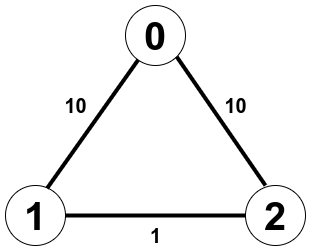

####No. of Layers => 1

In [13]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  6.4948663
Score after step 20 =>  7.6790775
Score after step 30 =>  8.6267677
Score after step 40 =>  9.0739810
Score after step 50 =>  9.3852252
Score after step 60 =>  9.5301053
Score after step 70 =>  9.5904418
Score after step 80 =>  9.6144694
Score after step 90 =>  9.6238498
Score after step 100 =>  9.6274769
Optimized (gamma, beta) parameters:
[[-0.51844101]
 [ 0.47799636]]
Most frequently sampled bit string is: 100





####No. of Layers => 2

In [14]:
result_layer_2 = optimize_weighted_maxcut(layers = 2)

No of Layers =>  2
Score after step 10 =>  6.6732709
Score after step 20 =>  4.6870285
Score after step 30 =>  9.3992198
Score after step 40 =>  1.9677310
Score after step 50 =>  9.3625635
Score after step 60 =>  9.9361435
Score after step 70 =>  10.1949925
Score after step 80 =>  10.2202500
Score after step 90 =>  10.1446199
Score after step 100 =>  10.0404569
Optimized (gamma, beta) parameters:
[[0.52259305 0.04747062]
 [0.3514782  2.30996911]]
Most frequently sampled bit string is: 100





####No. of Layers => 3

In [15]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 => -5.8905941
Score after step 20 =>  5.2183821
Score after step 30 =>  5.8762619
Score after step 40 =>  10.2186448
Score after step 50 =>  10.5797628
Score after step 60 =>  10.7005910
Score after step 70 =>  9.0282091
Score after step 80 =>  8.4836929
Score after step 90 =>  9.3723462
Score after step 100 =>  10.0181733
Optimized (gamma, beta) parameters:
[[-0.60807782  2.29187656  0.1026099 ]
 [ 1.24184327  1.92393174  1.95640975]]
Most frequently sampled bit string is: 011





####No. of Layers => 4

In [16]:
result_layer_4 = optimize_weighted_maxcut(layers = 4)

No of Layers =>  4
Score after step 10 =>  5.5431205
Score after step 20 =>  6.5982040
Score after step 30 =>  4.7027763
Score after step 40 =>  5.8637106
Score after step 50 =>  9.7956284
Score after step 60 =>  10.6745352
Score after step 70 =>  9.7471574
Score after step 80 =>  9.9792272
Score after step 90 =>  10.2522416
Score after step 100 =>  10.4800784
Optimized (gamma, beta) parameters:
[[ 0.49094278  0.55570322 -0.03892495  0.83938762]
 [-0.44848432 -0.11605172 -0.11944708 -0.13110236]]
Most frequently sampled bit string is: 100





####No. of Layers => 5

In [17]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 => -2.5424457
Score after step 20 =>  0.6634548
Score after step 30 =>  3.7651490
Score after step 40 =>  6.3055411
Score after step 50 =>  5.5078614
Score after step 60 =>  8.4219516
Score after step 70 =>  6.5280459
Score after step 80 =>  9.9825032
Score after step 90 =>  10.6247076
Score after step 100 =>  10.8238636
Optimized (gamma, beta) parameters:
[[-0.06448669  1.67925016  0.75201222  2.15970456  2.51244051]
 [ 2.80152207 -1.28793957  2.05657572 -0.21600493 -1.43467265]]
Most frequently sampled bit string is: 100





####No. of Layers => 6

In [18]:
result_layer_6 = optimize_weighted_maxcut(layers = 6)

No of Layers =>  6
Score after step 10 =>  8.0022817
Score after step 20 => -6.8324949
Score after step 30 =>  8.3783633
Score after step 40 =>  3.6853842
Score after step 50 =>  9.4678334
Score after step 60 =>  6.7655945
Score after step 70 => -5.9374093
Score after step 80 => -0.6873454
Score after step 90 =>  7.4476598
Score after step 100 =>  7.2760623
Optimized (gamma, beta) parameters:
[[ 1.4170846   0.18307292  0.75344331 -1.1095489   3.01938071  1.79739506]
 [ 1.71047005  1.29466316  1.88057226  2.9082053   0.17340962  1.17506628]]
Most frequently sampled bit string is: 100





####Partitioned Graph

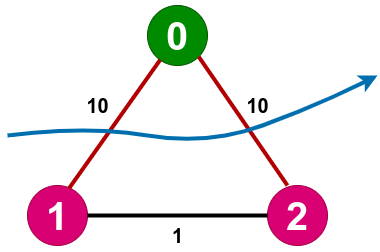

####Histograms

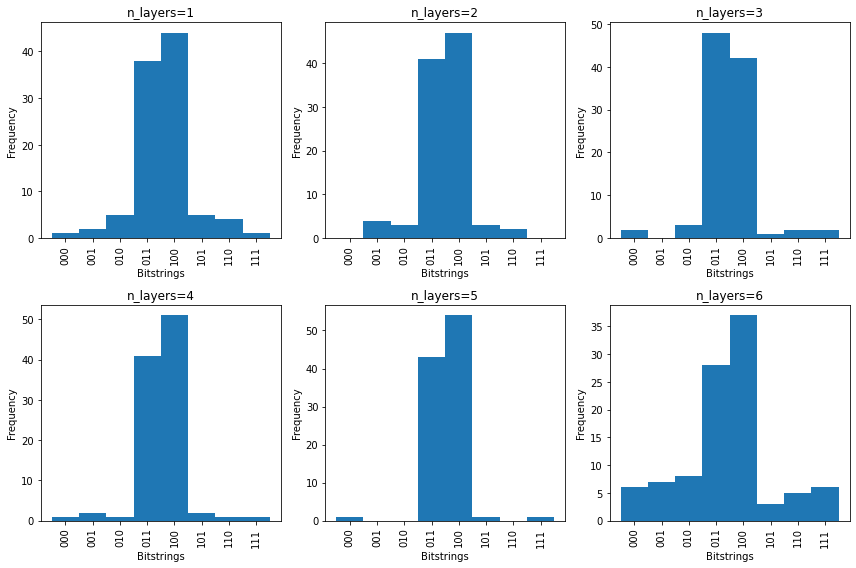

In [19]:
import matplotlib.pyplot as plt

xticks = range(0, 8)
xtick_labels = list(map(lambda x: format(x, "03b"), xticks))
bins = np.arange(0, 9) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=6")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_6[1], bins=bins)

plt.tight_layout()
plt.show()

*Conclusion - Here the MAXCUT solution is quite simple and sum of weiights of cut edges is $(10+10)=20$*. Here as we can see from single layer circuit upto 5 layers, the probablity amplitude of states other than the targetted was decreasing. But unexpectedly at six layered circuit, those states got amplified a little bit. 

## Test case 2

This test case although shown as weighted graph, is basically a unweighted grpah and the all weights are set to $1$ to make fir as input to this solution. 

This graph I tried to check how general the solution is. 

In [24]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
weight = [1.0, 1.0, 1.0, 1.0]


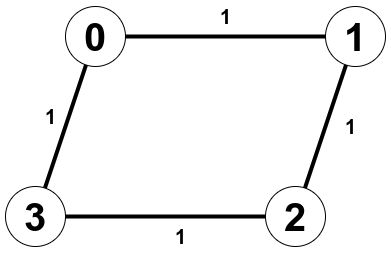

####No. of Layers => 1

In [25]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  2.9964974
Score after step 20 =>  2.9999489
Score after step 30 =>  2.9999993
Score after step 40 =>  3.0000000
Score after step 50 =>  3.0000000
Score after step 60 =>  3.0000000
Score after step 70 =>  3.0000000
Score after step 80 =>  3.0000000
Score after step 90 =>  3.0000000
Score after step 100 =>  3.0000000
Optimized (gamma, beta) parameters:
[[0.78539816]
 [0.39269908]]
Most frequently sampled bit string is: 0101





####No. of Layers => 2

In [26]:
result_layer_2 = optimize_weighted_maxcut(layers = 2)

No of Layers =>  2
Score after step 10 =>  3.6946433
Score after step 20 =>  3.9889723
Score after step 30 =>  3.9994953
Score after step 40 =>  3.9999661
Score after step 50 =>  3.9999975
Score after step 60 =>  3.9999998
Score after step 70 =>  4.0000000
Score after step 80 =>  4.0000000
Score after step 90 =>  4.0000000
Score after step 100 =>  4.0000000
Optimized (gamma, beta) parameters:
[[ 1.57079633  0.78539816]
 [ 0.39269872 -0.78539859]]
Most frequently sampled bit string is: 0101





####No. of Layers => 3

In [27]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 =>  3.5132449
Score after step 20 =>  3.9952798
Score after step 30 =>  3.9999360
Score after step 40 =>  3.9999991
Score after step 50 =>  4.0000000
Score after step 60 =>  4.0000000
Score after step 70 =>  4.0000000
Score after step 80 =>  4.0000000
Score after step 90 =>  4.0000000
Score after step 100 =>  4.0000000
Optimized (gamma, beta) parameters:
[[ 0.18350377  1.30975554  0.91539981]
 [-0.2042319   0.41045867 -0.79804043]]
Most frequently sampled bit string is: 0101





####No. of Layers => 4

In [28]:
result_layer_4 = optimize_weighted_maxcut(layers = 4)

No of Layers =>  4
Score after step 10 =>  3.0220496
Score after step 20 =>  3.7952009
Score after step 30 =>  3.9607994
Score after step 40 =>  3.9925919
Score after step 50 =>  3.9986079
Score after step 60 =>  3.9997391
Score after step 70 =>  3.9999511
Score after step 80 =>  3.9999909
Score after step 90 =>  3.9999983
Score after step 100 =>  3.9999997
Optimized (gamma, beta) parameters:
[[-0.35048359 -0.27975924 -0.93802107  0.28249736]
 [ 1.35185557  1.26391722  0.69099843  0.5193599 ]]
Most frequently sampled bit string is: 0101





####No. of Layers => 5

In [29]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 =>  2.3167395
Score after step 20 =>  3.8308488
Score after step 30 =>  3.9986764
Score after step 40 =>  3.9996941
Score after step 50 =>  3.9997505
Score after step 60 =>  3.9998031
Score after step 70 =>  3.9998501
Score after step 80 =>  3.9998888
Score after step 90 =>  3.9999192
Score after step 100 =>  3.9999422
Optimized (gamma, beta) parameters:
[[ 0.22077725  0.17372443 -0.38604035  0.61470626  1.26840481]
 [ 0.83202093  0.8650568   0.68266331  0.64317479  0.43384227]]
Most frequently sampled bit string is: 0101





####No. of Layers => 6

In [30]:
result_layer_6 = optimize_weighted_maxcut(layers = 6)

No of Layers =>  6
Score after step 10 =>  2.9001541
Score after step 20 =>  2.8067119
Score after step 30 =>  3.8669792
Score after step 40 =>  3.7539512
Score after step 50 =>  3.8480151
Score after step 60 =>  3.9877504
Score after step 70 =>  3.9975533
Score after step 80 =>  3.9875513
Score after step 90 =>  3.9524204
Score after step 100 =>  3.9823109
Optimized (gamma, beta) parameters:
[[ 1.23931565  1.28869742 -0.2587735  -0.10302438 -0.49603709 -0.14375951]
 [ 0.21657561  1.16940427  1.85560998  1.12777928  1.35497854  0.11629292]]
Most frequently sampled bit string is: 0101





####Partitioned Graph

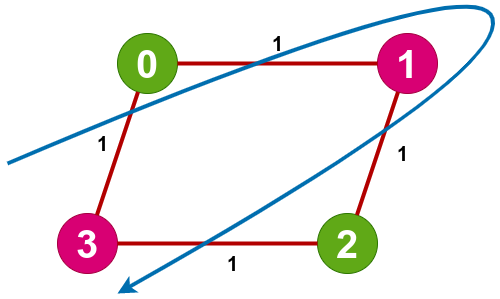

####Histograms

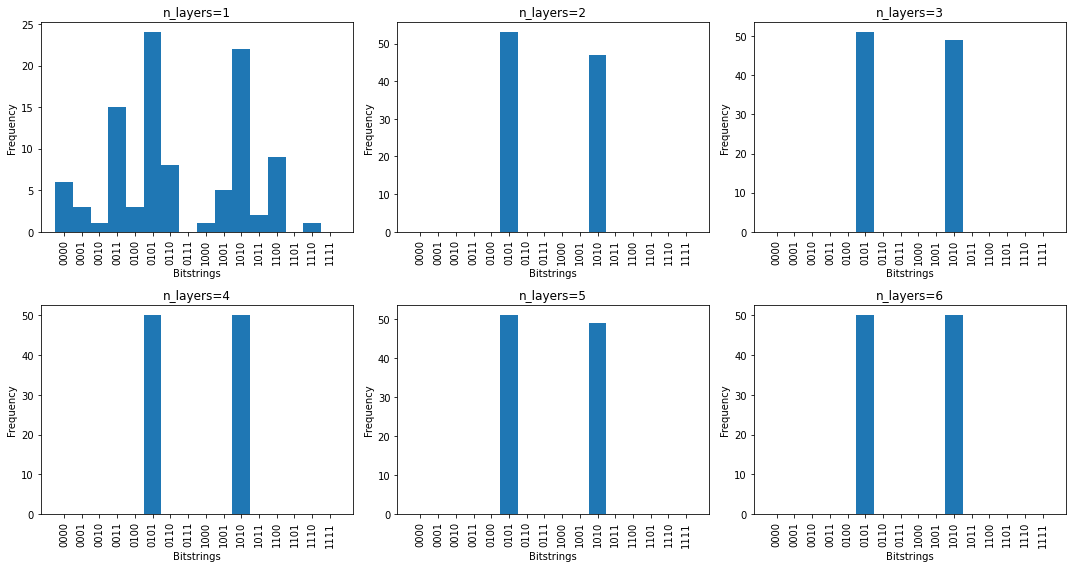

In [31]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=6")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_6[1], bins=bins)

plt.tight_layout()
plt.show()

*Conclusion - The partition passes through all four edges present in the graph. Sum of weights herre is $4$ which is the maximum possible value*. Here its clear that two layered circuit is enough to get the solution as the graph is simple, still we tried upto six only for the sake of experimental results. 

## Test Case 3

This one is the most complex among all three cases. It consists of $5$ nodes numbered from $0$ - $4$ and $6$ edges connecting them, with the weights written on them. 

In [37]:
n_wires = 5
graph = [(0,1), (0,2), (1,2), (1,3), (2,3), (3,4)]
weight = [5.0, 1.0, 7.0, 4.0, 2.0, 3.0]


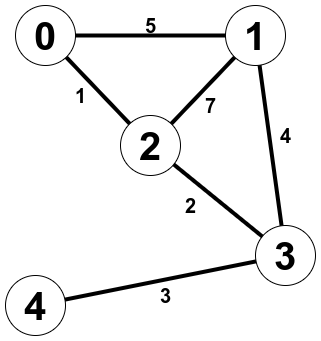

####No. of Layers => 1

In [41]:
result_layer_1 = optimize_weighted_maxcut(layers = 1)

No of Layers =>  1
Score after step 10 =>  4.6222117
Score after step 20 =>  4.9664158
Score after step 30 =>  5.0257845
Score after step 40 =>  5.1366069
Score after step 50 =>  5.1995714
Score after step 60 =>  5.2336053
Score after step 70 =>  5.2504637
Score after step 80 =>  5.2584510
Score after step 90 =>  5.2621502
Score after step 100 =>  5.2638433
Score after step 110 =>  5.2646134
Score after step 120 =>  5.2649625
Optimized (gamma, beta) parameters:
[[-0.44386407]
 [ 1.07517764]]
Most frequently sampled bit string is: 10110





####No. of Layers => 2

In [43]:
result_layer_2 = optimize_weighted_maxcut(layers = 2)

No of Layers =>  2
Score after step 10 =>  2.7875785
Score after step 20 =>  2.4677453
Score after step 30 =>  2.8705755
Score after step 40 =>  5.8973799
Score after step 50 =>  7.2400230
Score after step 60 =>  7.3607977
Score after step 70 =>  7.4901125
Score after step 80 =>  7.5814844
Score after step 90 =>  7.6404724
Score after step 100 =>  7.6834179
Score after step 110 =>  7.7149241
Score after step 120 =>  7.7384518
Optimized (gamma, beta) parameters:
[[0.15761225 1.76069959]
 [0.4934585  0.43433606]]
Most frequently sampled bit string is: 10110





####No. of Layers => 3

In [46]:
result_layer_3 = optimize_weighted_maxcut(layers = 3)

No of Layers =>  3
Score after step 10 =>  3.9330068
Score after step 20 =>  6.7196970
Score after step 30 =>  7.9495111
Score after step 40 =>  8.0855879
Score after step 50 =>  8.1274704
Score after step 60 =>  8.1540119
Score after step 70 =>  8.1722726
Score after step 80 =>  8.1853510
Score after step 90 =>  8.1949462
Score after step 100 =>  8.2020933
Score after step 110 =>  8.2074691
Score after step 120 =>  8.2115380
Optimized (gamma, beta) parameters:
[[-0.00435447  1.04698023  0.53430835]
 [ 1.2353825   1.33179045  0.59159945]]
Most frequently sampled bit string is: 10110





####No. of Layers => 4

In [49]:
result_layer_4 = optimize_weighted_maxcut(layers = 4)

No of Layers =>  4
Score after step 10 =>  0.4872781
Score after step 20 =>  5.7915707
Score after step 30 => -0.1778987
Score after step 40 =>  7.4842558
Score after step 50 =>  4.7046617
Score after step 60 =>  7.8486598
Score after step 70 =>  7.2790255
Score after step 80 =>  5.6419990
Score after step 90 =>  7.8286033
Score after step 100 =>  8.1187012
Score after step 110 =>  8.1175357
Score after step 120 =>  8.1683584
Optimized (gamma, beta) parameters:
[[-0.63816077 -1.28387527 -0.73444699 -0.35929313]
 [-0.07776821  0.63588708 -1.09284781  0.71850985]]
Most frequently sampled bit string is: 01001





####No. of Layers => 5

In [51]:
result_layer_5 = optimize_weighted_maxcut(layers = 5)

No of Layers =>  5
Score after step 10 =>  2.7519821
Score after step 20 =>  2.9364340
Score after step 30 =>  5.6929036
Score after step 40 =>  4.2740460
Score after step 50 =>  6.8371290
Score after step 60 =>  8.4680531
Score after step 70 =>  8.5473247
Score after step 80 =>  8.3615112
Score after step 90 =>  8.6367871
Score after step 100 =>  8.5752323
Score after step 110 =>  8.6730671
Score after step 120 =>  8.4240274
Optimized (gamma, beta) parameters:
[[-0.52890414 -1.03598861  0.41017614 -1.12615192  0.37120171]
 [-1.25166485 -0.79534033 -0.57924368  1.9033066   1.43909654]]
Most frequently sampled bit string is: 01001





####No. of Layers => 7

In [64]:
result_layer_7 = optimize_weighted_maxcut(layers = 7)

No of Layers =>  7
Score after step 10 =>  1.8669340
Score after step 20 =>  5.3899723
Score after step 30 =>  3.9481907
Score after step 40 =>  6.8486145
Score after step 50 =>  6.6981280
Score after step 60 =>  7.7076665
Score after step 70 =>  6.4987497
Score after step 80 =>  7.7773723
Score after step 90 =>  8.2822798
Score after step 100 =>  8.3119791
Score after step 110 =>  8.2353937
Score after step 120 =>  8.4426088
Optimized (gamma, beta) parameters:
[[-0.65319173  1.26643337  1.39680408  1.40762127  0.90767636  2.18585957
   0.96944993]
 [ 1.68431885 -0.68243875  1.16863324  0.51432418  0.64680497 -0.01473988
  -0.02640006]]
Most frequently sampled bit string is: 10110





#### Partitioned Graph

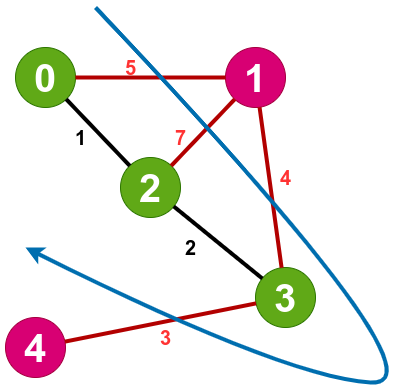

####Histograms

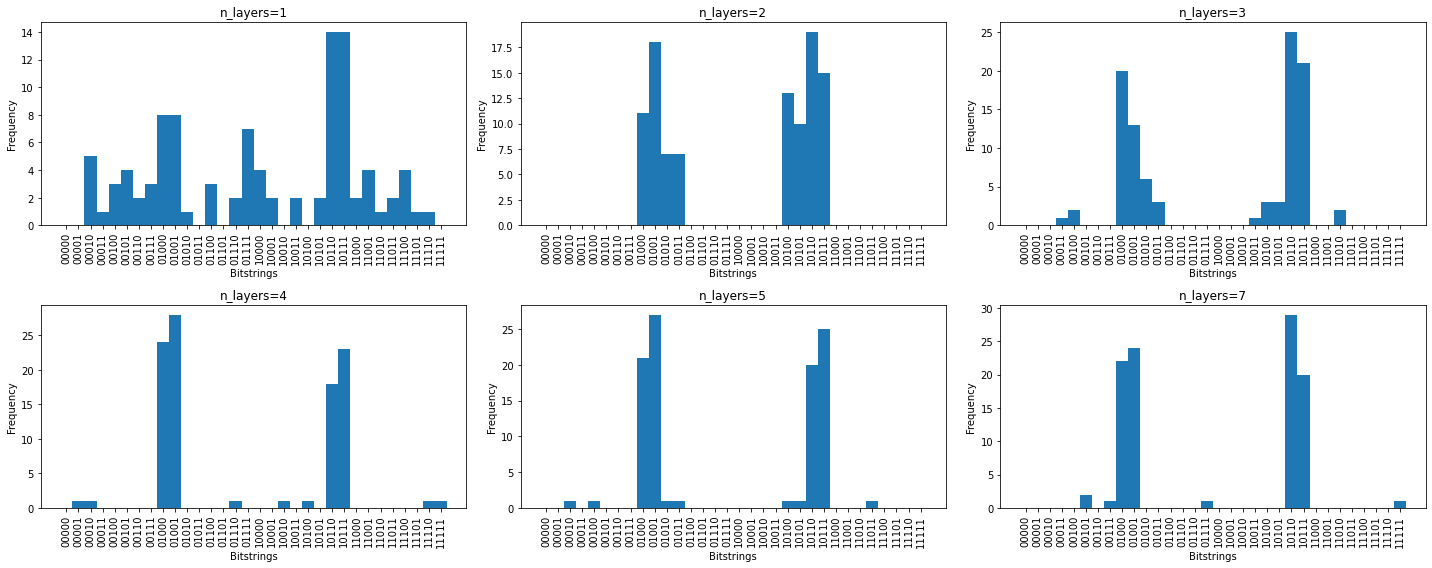

In [65]:
import matplotlib.pyplot as plt

xticks = range(0, 32)
xtick_labels = list(map(lambda x: format(x, "05b"), xticks))
bins = np.arange(0, 33) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=7")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(result_layer_7[1], bins=bins)

plt.tight_layout()
plt.show()

*Conclusion - In this test case, the solution partition passes through $4$ out of $6$ edges, summing the weights to $(5+7+4+3) = 19$*. Also its clear that with increasing no. of layers, probablity amplitudes of states other than the targetted one is reducing drastically. 

For complex graphs like this test case 3, circuits with lesser number of layers doesn't have 100% accuracy, its possible that sometimes they give incorrect result, as seen from previous experimental results. 